In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from statistics import mean
import os
from sklearn.metrics.pairwise import euclidean_distances
import math

# Code

In [20]:
def read_barcodes(barcodes_file):
    barcodes = pd.read_csv(barcodes_file, sep = '\t',header = None)
    barcodes.columns = ['barcode']
    barcodes.index += 1
    barcodes['barcode_id'] = barcodes.index
    return barcodes

def read_features(features_file):
    features = pd.read_csv(features_file, sep = '\t',header = None)
    features.index += 1
    features.columns = ['feature_code','value','type']
    features['feature_id'] = features.index
    features['feature_id'] = pd.to_numeric(features['feature_id'])
    return features

def read_matrix(matrix_file):
    matrix = pd.read_csv(matrix_file,sep = '\t')
    matrix = matrix.drop([0])
    matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
    matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
    matrix = matrix.apply(pd.to_numeric)
    matrix['count']=matrix['count'].astype(int)
    return matrix

def merge_matrix(matrix,barcodes,features):
    matrix = pd.merge(matrix, barcodes, on="barcode_id")
    matrix = pd.merge(matrix, features, on="feature_id")
    #matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
    return matrix


def get_value_matrix(matrix):
    v_t = matrix['value'].str.split('_',n=1,expand=True)
    matrix['value']=v_t[0]
    matrix['value_type']=v_t[1]
    return matrix

## we dont use it here
def get_tetramer_matrix(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    #tetramers = tetramers[tetramers['count']>5]
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode_id','tetramer']]
    matrix = pd.merge(matrix, tetramers, on="barcode_id")
    return matrix[['barcode','value','tetramer','count']]

def get_barcode_tetramer(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode','tetramer','count']]
    return tetramers

In [25]:
def prep_annot_data(data):
    data_c = data[data['is_cell']==True].reset_index(drop=True)
    data_c = data_c[data_c['chain'] == "TRB"]
    
    data_c = data_c[-data_c['v_gene'].isna()]
    data_c = data_c[-data_c['j_gene'].isna()]
    
    data_c = data_c[-data_c['cdr3'].isna()]
    #data_no_10x = data_no_10x[-data_no_10x['antigen.epitope'].isna()]
    data_c = data_c[-data_c['v_gene'].str.contains(',')]
    data_c = data_c[-data_c['j_gene'].str.contains(',')]
    data_c = data_c[-data_c['cdr3'].str.contains('\*')]
    data_c = data_c[data_c['cdr3']!='None']
    data_c = data_c[data_c['v_gene']!='None']
    data_c = data_c[data_c['j_gene']!='None']
    return data_c

def merge_anot_matrix(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    #data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    #data_c = data_c[data_c['cdr3']!='None']
    return data_c

In [28]:
def aminoacid_to_nt(cdr3):
    gene_code = {"A":"GCT", "C":"TGT", "T":"ACT", "S":"TCT", "F": "TTT", "L":"TTA", "I":"ATT", 
                 "M":"ATG", "V":"GTT", "P":"CCT", "Y":"TAT", "H":"CAT","Q": "CAA", "N":"AAT", 
                 "K":"AAA", "D":"GAT", "E":"GAA", "W":"TGG", "R":"CGT", "G":"GGT"}
    res = ''.join([gene_code.get(i) for i in list(cdr3)])
    return res

def filter_table(data,chain):
    if chain== "TRA":
        data = data[data['chain'] == "TRA"]
    
    if chain== "TRB":
        data = data[data['chain'] == "TRB"]
    #cols_input = list(data.columns)
    data = data[-data['v_gene'].isna()]
    data = data[-data['j_gene'].isna()]
    data = data[-(data['v_gene']== "None")]
    data = data[-(data['j_gene']== "None")]
    data = data[-(data['j_gene']== "")]
    data = data[-(data['v_gene']== "")]
    data = data[-data['v_gene'].str.contains(',')]
    data = data[-data['j_gene'].str.contains(',')]

    data = data[-(data['cdr3']== "")]
    data = data[-(data['cdr3']== "None")]
    data = data[-data['cdr3'].isna()]
    data = data[-data['cdr3'].str.contains('\.')]
    data = data[-data['cdr3'].str.contains('\*')]
    
    data = data[data['high_confidence']==True]
    data = data.reset_index(drop=True)
    return data
    
def columns_prep(data):

    data = data.assign(d_gene = ".")
    data = data.assign(count = 1)
    data['DStart'] =  -1
    data['DEnd'] =  -1
    data['VEnd'] =  -1
    data['JStart'] =  -1
    data['freq'] =  -1
    data['cdr3nt'] = data['cdr3'].apply(lambda x: aminoacid_to_nt(x))
    
    data = data.rename(columns={"cdr3": "cdr3aa"})
    data = data.rename(columns={"v_gene": "v"})
    data = data.rename(columns={"j_gene": "j"})
    data = data.assign(subset = ".")
    #data = data.rename(columns={"value": "subset"})
    #data = data.rename(columns={"cdr3_nt": "cdr3nt"})

    cols = ["count", "freq", "cdr3aa", "cdr3nt", "v", "d", "j", "VEnd", "DStart", "DEnd","JStart","contig_id","reads","umis","length","subset"]
    data.drop(set(data.columns) - set(cols), axis=1, inplace=True)
    return data

In [40]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

In [41]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

# Data proc and prep

## matrix and barcode

In [3]:
barcodes = read_barcodes('data/filtered_feature_bc_matrix/barcodes.tsv')

features = read_features('data/filtered_feature_bc_matrix/features.tsv')

matrix = read_matrix('data/filtered_feature_bc_matrix/matrix.mtx')

matrix_2 = merge_matrix(matrix,barcodes,features)
matrix_2 = get_value_matrix(matrix_2)

matrix_3 = matrix_2[matrix_2['type']=='Antibody Capture']
matrix_3 = matrix_3[matrix_3['value_type']!='TotalSeqC']

matrix_t = get_tetramer_matrix(matrix_3)
matrix_t


,barcode,barcode_id
1,AAACGGGAGAAGATTC-1,1
2,AAACGGGTCGGACAAG-1,2
3,AAAGATGGTACAGACG-1,3
4,AAAGTAGAGACGCTTT-1,4
5,AAAGTAGAGCGCTTAT-1,5
...,...,...
55202,TTTGTCAAGGACAGCT-40,55202
55203,TTTGTCAAGGGTCTCC-40,55203
55204,TTTGTCACACGTCTCT-40,55204
55205,TTTGTCAGTTACGCGC-40,55205


In [96]:
barcode_tetramer = get_barcode_tetramer(matrix_3)
barcode_tetramer

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,barcode,tetramer,count
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL,76112470
38209278,AACCGCGCATCCGGGT-36,IVTDFSVIK,1377
38240451,CGTTGGGGTAAGTAGT-36,AVFDRKSDAK,1353
38240788,GTGAAGGCAACCGCCA-36,AVFDRKSDAK,1341
38240930,TCGTAGAAGTCCGGTC-36,AVFDRKSDAK,1277
...,...,...,...
17062251,CCTTTCTGTTGCCTCT-34,KLGGALQAK,1
61364026,TGACAACGTTCGGCAC-8,KVAELVHFL,1
17062217,CCGGGATCACGGTTTA-34,KLGGALQAK,1
61363854,TGTGTTTTCCCAACGG-6,KVAELVHFL,1


## annot data

In [141]:
data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot = data.copy()
data_c_annot = data_c_annot[data_c_annot['is_cell']==True].reset_index(drop=True)
data_c_annot = filter_table(data_c_annot,'TRB')
data_c = data_c_annot.copy()
data_c = merge_anot_matrix(data_c,barcode_tetramer)
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1,AVFDRKSDAK,2
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1,AVFDRKSDAK,5
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1,CLLGTYTQDV,1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1,RAKFKQLL,1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2,RLRAEAQVK,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45171,TTTGTCATCGAGGTAG-13,True,TTTGTCATCGAGGTAG-13_contig_3,True,679,TRB,TRBV19,None,TRBJ1-5,TRBC1,True,True,CASSTSNEQPQHF,TGTGCCAGTAGTACGTCGAATGAACAGCCCCAGCATTTT,2415,2,clonotype30336,clonotype30336_consensus_2,GILGFVFTL,67
45172,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2,IVTDFSVIK,2
45173,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1,AVFDRKSDAK,14
45174,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2,KLGGALQAK,28


# Analysis

## with KLG

In [100]:
data_c_mir = columns_prep(data_c)
data_c_mir

In [102]:
#temp file
file_date = '110623'
file_path = 'data/10x_trb_' + file_date +'.txt'
data_c_mir.to_csv(file_path, sep='\t', index = False)

In [103]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "/home/yuliajk/projects/tcr_emb_2022/data/prototypes_280322.txt"
input_data_path = 'data/10x_trb_' + file_date +'.txt'
output_path = "data_scripts/10x_trb_" + file_date + "_"

#command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
#os.system(command)




In [104]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

0

In [105]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_mir = pd.read_csv(input_data_path, sep='\t')
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACAAAGG-4_contig_1,722,TRBV10-3,TRBJ2-1,CAISDPGLAGGGGEQFF,32237,18,1,-1,-1,-1,-1,-1,TGTGCTATTTCTGATCCTGGTTTAGCTGGTGGTGGTGGTGAACAAT...,.
1,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
2,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
3,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
4,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45171,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
45172,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
45173,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.
45174,TTTGTCATCTGTCAAG-32_contig_1,701,TRBV7-6,TRBJ2-3,CASSLGASRSTDTQYF,12473,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGCTTCTCGTTCTACTGATACTCAATATTTT,.


In [106]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,137.0,54.0,22.0
1,1,2,141.0,41.0,9.0
2,1,3,323.0,45.0,7.0
3,1,4,161.0,54.0,9.0
4,1,5,102.0,85.0,37.0
...,...,...,...,...,...
13552795,45176,296,125.0,47.0,5.0
13552796,45176,297,91.0,47.0,9.0
13552797,45176,298,184.0,47.0,11.0
13552798,45176,299,94.0,47.0,13.0


In [107]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id1',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id1',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c['barcode'],drop = True)

In [108]:
pca_df, pca_model = pca(data_c_b_dist,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index

In [110]:
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data

,barcode,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,tetramer
0,AAACCTGAGACAAAGG-4,-9.137713,9.757100,-1.574494,-4.127797,7.564510,-4.867501,-5.722929,11.618894,-1.900164,...,-0.775246,1.831913,-0.061497,0.736302,-0.665874,-0.430156,-1.072767,-0.436380,-0.425808,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,-3.558548,-5.446727,4.722284,1.025839,8.310293,-2.740593,-3.714857,15.109426,7.304572,...,2.333529,-0.136824,-0.648552,0.635977,0.951558,-1.134688,1.062547,-1.688383,-0.729511,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,-16.540715,-11.068314,-6.146355,10.434186,-4.303534,-8.316892,9.583948,-1.176309,2.623571,...,2.653947,1.463760,-0.002971,-0.424258,-0.806803,-0.419631,0.602577,0.154016,-1.811086,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,-16.702118,-10.901686,-2.808375,-7.212988,-1.889785,5.604861,13.248985,-4.704230,3.104579,...,2.174903,0.846458,-0.355345,0.484174,0.098006,0.177081,-0.644708,-1.849592,-0.400036,RAKFKQLL
4,AAACCTGAGAGGGATA-8,-15.406110,-2.669989,-1.663542,-2.921617,9.046718,-1.951404,6.970172,8.161433,-12.917855,...,-2.603594,0.463076,0.593213,-1.533805,-1.942074,0.869120,-1.440013,-0.119512,-0.807410,RLRAEAQVK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42727,TTTGTCATCGAGGTAG-13,3.683883,9.687544,-9.481596,16.570458,-7.930748,17.039430,-2.762218,0.866860,-1.691249,...,-0.105124,-0.261968,0.209052,-0.970367,0.315784,-0.619659,-0.069876,-1.420747,-1.250022,GILGFVFTL
42728,TTTGTCATCTCCAACC-24,-13.792808,-15.561276,2.061255,-4.064794,12.644057,1.347300,-7.515945,6.060674,-7.182872,...,-1.710962,-0.210443,-0.520951,-1.558517,-0.902793,1.728895,0.740523,1.069375,-0.003230,IVTDFSVIK
42729,TTTGTCATCTCCTATA-36,-17.899822,-3.289416,-0.274975,-3.811918,-0.932805,3.468353,9.189217,-1.600980,-8.084522,...,0.193030,-0.733271,0.418345,0.084280,-2.206543,-1.857232,-0.253422,0.093627,1.362307,AVFDRKSDAK
42730,TTTGTCATCTGTCAAG-32,-15.575425,-17.905246,-0.651061,9.233382,-2.399607,-6.671995,-8.546366,-0.907764,2.045769,...,-1.178491,1.809164,0.912547,-0.839714,0.586174,-0.216607,0.257792,-0.029779,-0.378543,KLGGALQAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 component')

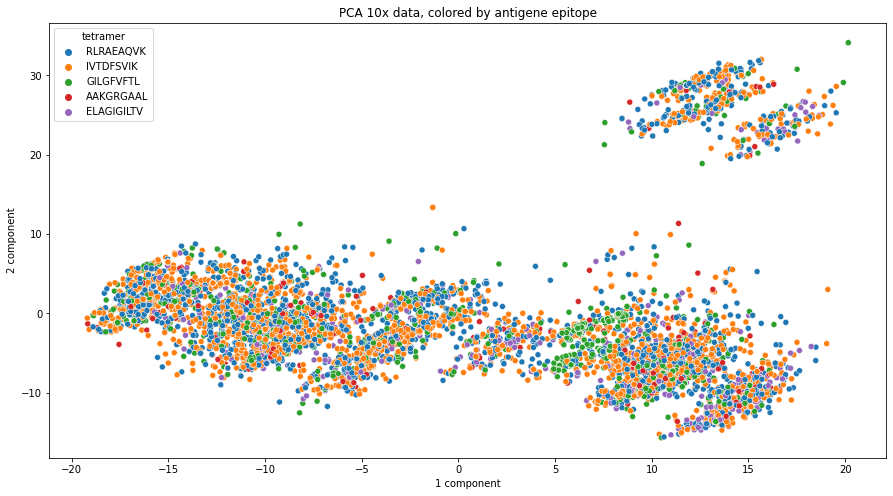

In [111]:
pc1 = 1
pc2 = 2
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data[pca_df_data['tetramer'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [118]:
X_embedded = tsne(pca_df,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])

In [119]:

tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

In [120]:
tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer
0,AAACCTGAGACAAAGG-4,-3.278172,20.447632,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,0.749302,-21.778469,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,-50.901566,-36.769169,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,-39.650005,-37.794827,RAKFKQLL
4,AAACCTGAGAGGGATA-8,-23.829042,-6.005056,RLRAEAQVK
...,...,...,...,...
42727,TTTGTCATCGAGGTAG-13,7.857258,23.403610,GILGFVFTL
42728,TTTGTCATCTCCAACC-24,-18.345003,-47.913197,IVTDFSVIK
42729,TTTGTCATCTCCTATA-36,-61.572060,-6.123363,AVFDRKSDAK
42730,TTTGTCATCTGTCAAG-32,-65.137535,-59.803349,KLGGALQAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


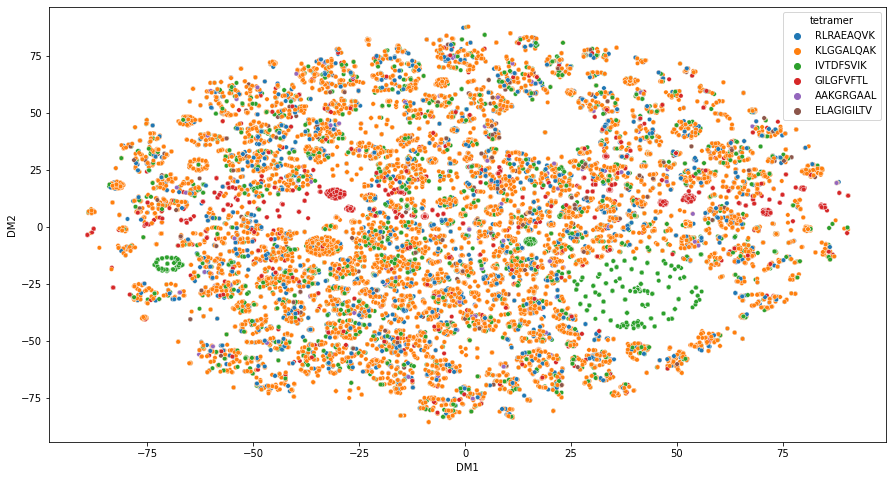

In [125]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


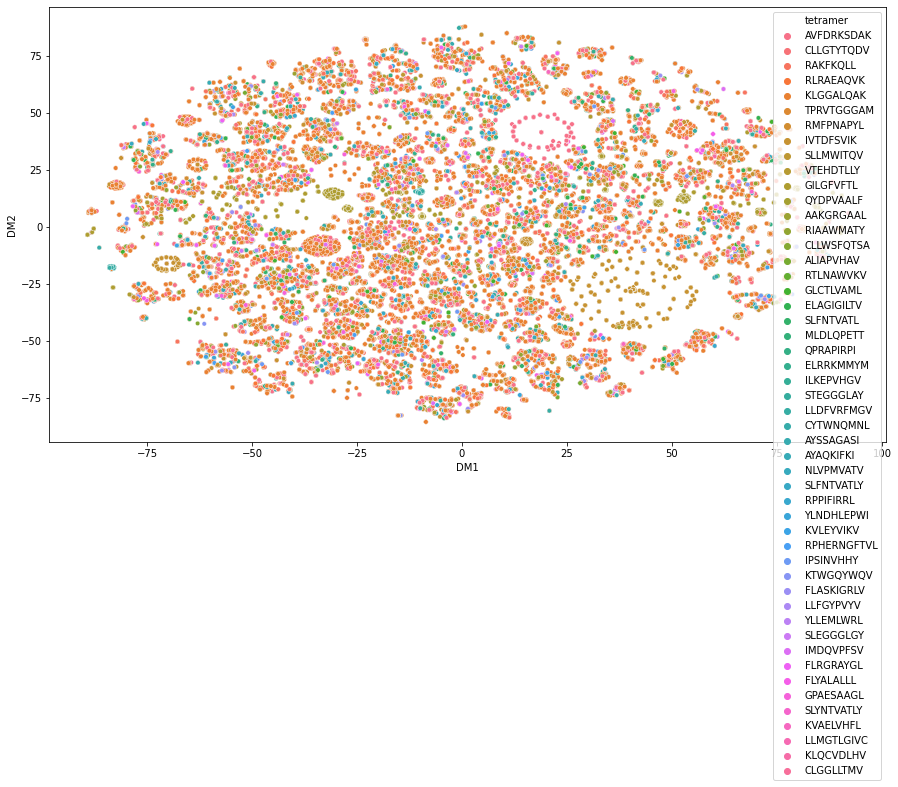

In [123]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

## without KLG

In [142]:
data_c = data_c[data_c['tetramer']!='KLGGALQAK'].reset_index(drop=True)

In [143]:
data_c_mir = columns_prep(data_c)
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACAAAGG-4_contig_1,722,TRBV10-3,TRBJ2-1,CAISDPGLAGGGGEQFF,32237,18,1,-1,-1,-1,-1,-1,TGTGCTATTTCTGATCCTGGTTTAGCTGGTGGTGGTGGTGAACAAT...,.
1,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
2,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
3,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
4,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30421,TTTGTCATCGAGCCCA-39_contig_1,686,TRBV7-9,TRBJ1-2,CASSLGGEKTF,15744,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGGTGAAAAAACTTTT,.
30422,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
30423,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
30424,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [144]:
#temp file
file_date = '120623'
file_path = 'data/10x_trb_' + file_date +'.txt'
data_c_mir.to_csv(file_path, sep='\t', index = False)

In [145]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "/home/yuliajk/projects/tcr_emb_2022/data/prototypes_280322.txt"
input_data_path = 'data/10x_trb_' + file_date +'.txt'
output_path = "data_scripts/10x_trb_" + file_date + "_"


In [146]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

0

In [147]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_mir = pd.read_csv(input_data_path, sep='\t')
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACAAAGG-4_contig_1,722,TRBV10-3,TRBJ2-1,CAISDPGLAGGGGEQFF,32237,18,1,-1,-1,-1,-1,-1,TGTGCTATTTCTGATCCTGGTTTAGCTGGTGGTGGTGGTGAACAAT...,.
1,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
2,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
3,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
4,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30421,TTTGTCATCGAGCCCA-39_contig_1,686,TRBV7-9,TRBJ1-2,CASSLGGEKTF,15744,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGGTGAAAAAACTTTT,.
30422,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
30423,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
30424,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [148]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,137.0,54.0,22.0
1,1,2,141.0,41.0,9.0
2,1,3,323.0,45.0,7.0
3,1,4,161.0,54.0,9.0
4,1,5,102.0,85.0,37.0
...,...,...,...,...,...
9127795,30426,296,125.0,47.0,5.0
9127796,30426,297,91.0,47.0,9.0
9127797,30426,298,184.0,47.0,11.0
9127798,30426,299,94.0,47.0,13.0


In [149]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id1',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id1',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c['barcode'],drop = True)

In [150]:
pca_df, pca_model = pca(data_c_b_dist,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data

,barcode,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,tetramer
0,AAACCTGAGACAAAGG-4,-10.970229,9.574534,0.030517,-2.070776,-7.123189,-5.089659,-6.475492,12.212557,-2.166496,...,0.143894,-2.189495,0.293406,-1.095993,-0.423939,-0.455216,-0.762664,-0.428553,0.254724,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,-4.481269,-5.805212,4.886016,2.884336,-8.429552,-2.149815,-4.498727,15.741560,6.892552,...,1.726342,1.053924,-0.823755,-0.359515,0.631000,-0.542766,1.221888,-2.164612,-0.433493,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,-17.701809,-12.201356,-5.927975,10.575585,4.884520,-7.684313,11.250825,0.162283,3.524438,...,3.116972,-0.333721,0.654669,0.302903,-0.937771,-0.440902,0.862938,0.038995,-1.256065,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,-17.681436,-12.168934,-4.214776,-6.903974,-0.648201,6.378010,12.785532,-3.841599,3.478359,...,2.819195,0.154593,0.002122,0.029338,0.133711,-0.654817,-0.623984,-1.688753,0.710646,RAKFKQLL
4,AAACCTGAGAGGGATA-8,-16.779081,-3.187357,-1.834606,-0.604890,-9.663334,-0.666494,5.165496,8.468896,-15.162456,...,-1.913690,-1.839382,1.029622,0.655094,-1.784146,0.408765,-1.381645,0.237301,-0.132792,RLRAEAQVK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39,19.814300,-12.894558,0.380416,-1.160701,-3.755680,-1.006698,-4.529752,-1.469874,5.016879,...,0.173183,-0.445584,1.443405,0.011493,-1.816858,-0.044637,0.339414,0.928101,-1.198177,AVFDRKSDAK
28752,TTTGTCATCGAGGTAG-13,1.088425,10.016936,-6.790221,16.012266,13.343646,17.222900,-4.325585,0.570565,-0.692731,...,-0.351470,-0.092451,0.161445,1.178533,-0.159886,-0.724179,-0.210453,-1.391813,-1.536305,GILGFVFTL
28753,TTTGTCATCTCCAACC-24,-14.150191,-16.065956,1.144213,-0.955573,-13.893646,0.697067,-9.742531,5.220260,-6.888489,...,-1.004234,-0.728295,-0.293318,1.382989,-0.726041,1.670996,0.328188,1.251014,0.517251,IVTDFSVIK
28754,TTTGTCATCTCCTATA-36,-19.108817,-4.757982,-0.906120,-3.780830,-0.136624,4.013763,7.906913,-1.682117,-10.832143,...,-0.421496,0.539893,0.528440,-1.287050,-2.623292,-1.193073,0.959921,0.242997,0.864393,AVFDRKSDAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 component')

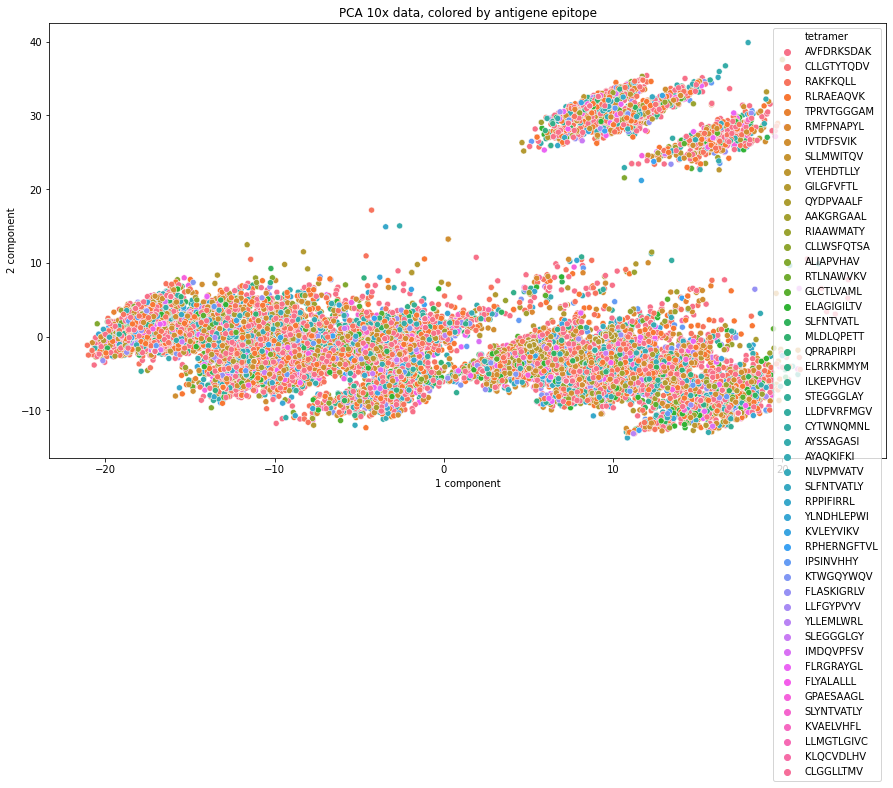

In [151]:
pc1 = 1
pc2 = 2
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [163]:
X_embedded = tsne(pca_df,2,0,50)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer
0,AAACCTGAGACAAAGG-4,-10.614143,55.457600,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,-8.204803,-18.856544,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,-56.662136,-37.761478,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,-32.590172,-24.495918,RAKFKQLL
4,AAACCTGAGAGGGATA-8,-25.694559,0.428836,RLRAEAQVK
...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39,67.149803,-17.702457,AVFDRKSDAK
28752,TTTGTCATCGAGGTAG-13,-0.639018,19.674137,GILGFVFTL
28753,TTTGTCATCTCCAACC-24,-6.417595,-41.399693,IVTDFSVIK
28754,TTTGTCATCTCCTATA-36,-37.643467,-15.917512,AVFDRKSDAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


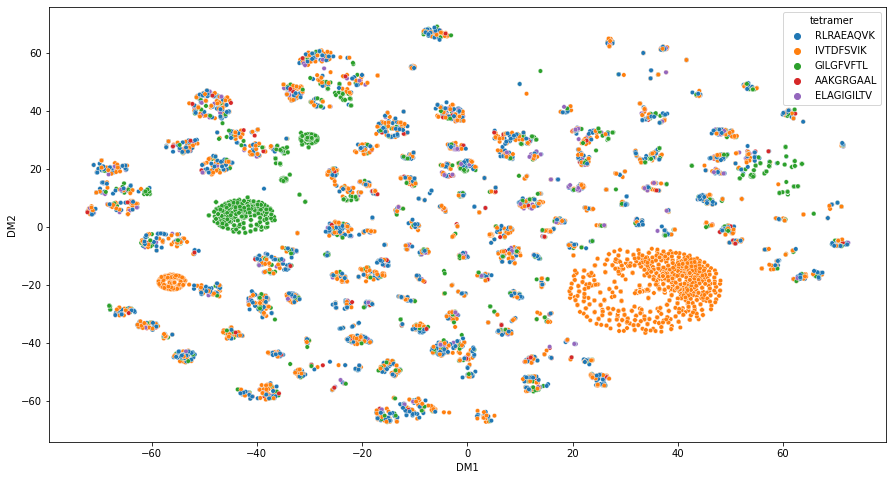

In [164]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


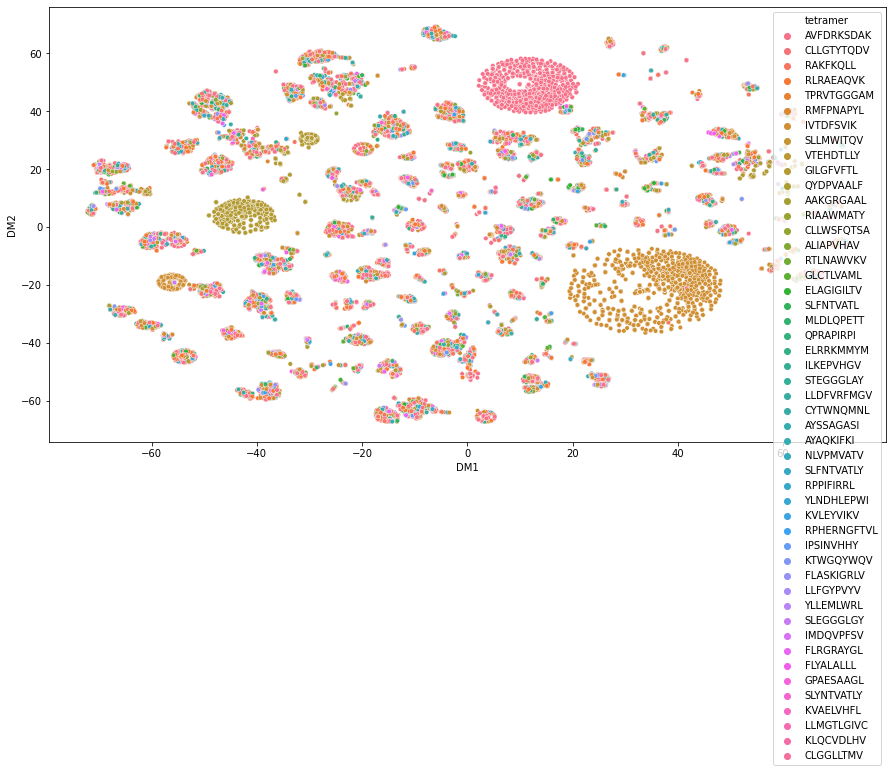

In [165]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")